In [12]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from FCNN import FCNN
from loss_function import CombinedLoss
from train_test2 import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets, plot_predictions_vs_targets_sr
from visualization import plot_mean_power_spectrum, plot_mean_power_spectrum_sr
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders, prepare_dataloaders_multiVar
from qualitative_eval import mse, r2_score, pearson_corr, first_esr_exceeds_half

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Useful Functions

In [4]:
def data_loader(train_data_HF, test_data_HF, train_data_LR, test_data_LR,
                var_LR=['u_relative'], var_HF='heatflux_diff',
                batch_size=32, normalization_type=None, val_split=0.2, return_norm_stats=True):
    """
    Prepare train/val/test DataLoaders from high- and low-resolution datasets.

    Args:
        train_data_HF: xarray.Dataset 
            High-resolution training data (to be split into train/val)
        test_data_HF: xarray.Dataset 
            High-resolution test data (held out entirely)
        train_data_LR: xarray.Dataset 
            Low-res training data
        test_data_LR: xarray.Dataset 
            Low-res test data
        var_LR: List[str] 
            List of LR variables to extract
        var_HF: str 
            HF target variable to extract
        batch_size: int 
            Batch size
        normalization_type: str or None 
            'standardization', 'normalization', or None
        val_split: float 
            Fraction of training set to use for validation
        return_norm_stats: bool 
            If True, return normalization statistics (mean/std or min/max)

    Returns:
        train_loader, val_loader, test_loader
        HF_test (np.ndarray), LR_test (np.ndarray)
        norm_stats (tuple or None): 
            - For 'standardization': (HF_mean, HF_std, LR_mean, LR_std)
            - For 'normalization': (HF_min, HF_max, LR_min, LR_max)
            - None if return_norm_stats=False or normalization_type=None
    """
    # ---- Split train_data into training and validation ----
    n_samples = len(train_data_HF.time)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    val_size = int(val_split * n_samples)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    HF_train_ds = train_data_HF.isel(time=train_indices)
    HF_val_ds   = train_data_HF.isel(time=val_indices)
    LR_train_ds = train_data_LR.isel(time=train_indices)
    LR_val_ds   = train_data_LR.isel(time=val_indices)

    # Keep test data separate
    HF_test_ds = test_data_HF
    LR_test_ds = test_data_LR

    print("Train size:", len(HF_train_ds.time))
    print("Val size:", len(HF_val_ds.time))
    print("Test size:", len(HF_test_ds.time))

    # ---- Extract variables ----
    HF_train = getattr(HF_train_ds, var_HF).values
    HF_val   = getattr(HF_val_ds, var_HF).values
    HF_test  = getattr(HF_test_ds, var_HF).values

    def stack_vars(ds, varlist):
        return np.stack([ds[v].values for v in varlist], axis=1)

    LR_train = stack_vars(LR_train_ds, var_LR)
    LR_val   = stack_vars(LR_val_ds, var_LR)
    LR_test  = stack_vars(LR_test_ds, var_LR)

    norm_stats = None

    # ---- Normalize if requested ----
    if normalization_type == 'standardization':
        HF_mean, HF_std = HF_train.mean(), HF_train.std()
        LR_mean = LR_train.mean(axis=(0, 2, 3), keepdims=True)
        LR_std  = LR_train.std(axis=(0, 2, 3), keepdims=True)

        HF_train = (HF_train - HF_mean) / HF_std
        HF_val   = (HF_val   - HF_mean) / HF_std
        HF_test  = (HF_test  - HF_mean) / HF_std

        LR_train = (LR_train - LR_mean) / LR_std
        LR_val   = (LR_val   - LR_mean) / LR_std
        LR_test  = (LR_test  - LR_mean) / LR_std

        if return_norm_stats:
            norm_stats = (HF_mean, HF_std)

    elif normalization_type == 'normalization':
        HF_min, HF_max = HF_train.min(), HF_train.max()
        LR_min = LR_train.min(axis=(0, 2, 3), keepdims=True)
        LR_max = LR_train.max(axis=(0, 2, 3), keepdims=True)

        HF_train = (HF_train - HF_min) / (HF_max - HF_min)
        HF_val   = (HF_val   - HF_min) / (HF_max - HF_min)
        HF_test  = (HF_test  - HF_min) / (HF_max - HF_min)

        LR_train = (LR_train - LR_min) / (LR_max - LR_min)
        LR_val   = (LR_val   - LR_min) / (LR_max - LR_min)
        LR_test  = (LR_test  - LR_min) / (LR_max - LR_min)

        if return_norm_stats:
            norm_stats = (HF_min, HF_max)

    # ---- Torch tensors ----
    x_train = torch.tensor(LR_train, dtype=torch.float32)
    y_train = torch.tensor(HF_train, dtype=torch.float32).unsqueeze(1)

    x_val = torch.tensor(LR_val, dtype=torch.float32)
    y_val = torch.tensor(HF_val, dtype=torch.float32).unsqueeze(1)

    x_test = torch.tensor(LR_test, dtype=torch.float32)
    y_test = torch.tensor(HF_test, dtype=torch.float32).unsqueeze(1)

    # ---- Datasets & Loaders ----
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, HF_test, LR_test, norm_stats

In [5]:
def crop_boxes(ds, boxes, max_points=150):
    """
    Crop dataset into regional boxes.

    Parameters
    ----------
    ds : xr.Dataset or xr.DataArray
        Input dataset with dimensions (time, yt_ocean, xt_ocean).
    boxes : list of tuples
        Each tuple defines (lat_min, lat_max, lon_min, lon_max).
    max_points : int, optional
        Max number of lat/lon points to keep in each cropped box.

    Returns
    -------
    cropped_boxes : list of xr.Dataset
        List of cropped boxes, with Boxes 11 & 12 concatenated.
    """
    
    cropped_boxes = []
    
    for i, (lat_min, lat_max, lon_min, lon_max) in enumerate(boxes, start=1):
        # Slice the box
        da_box = ds.sel(
            yt_ocean=slice(lat_min, lat_max),
            xt_ocean=slice(min(lon_min, lon_max), max(lon_min, lon_max))
        )

        # Trim to max_points in each direction
        lat_len = min(max_points, da_box.yt_ocean.size)
        lon_len = min(max_points, da_box.xt_ocean.size)
        da_box = da_box.isel(
            yt_ocean=slice(0, lat_len),
            xt_ocean=slice(0, lon_len)
        )

        # Shift Box 12 longitudes
        if i == 12:
            da_box = da_box.assign_coords(xt_ocean=da_box.xt_ocean + 360)

        cropped_boxes.append(da_box)

    # Concatenate Boxes 11 & 12
    if len(cropped_boxes) >= 12:
        combined_11_12 = xr.concat(cropped_boxes[10:12], dim="xt_ocean")
        del cropped_boxes[10:12]
        cropped_boxes.append(combined_11_12)

    return cropped_boxes

# Data Preprocessing

In [6]:
# Config choices Abigail chose

input_channels = 6
output_channels = 1
conv_layers = 7
kernel = 5
#init_bound = 0.5
kernel_hidden = 3
activation = "ReLU"
arch = "fcnn"

config={"input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "arch":arch,
        "conv_layers":conv_layers,
        "kernel":kernel,
        "kernel_hidden":kernel_hidden}

In [7]:
box_names = [
    "Gulf Stream",
    "South Atlantic",
    "Equator Atlantic",
    "Malvinas Current",
    "California Current",
    "South Pacific",
    "Kuroshio Extension",
    "North Pacific",
    "Southern Ocean (NZ)",
    "Agulhas Current",
    "Indian Ocean",
    "Arabian Sea"
]

boxes = [
    (30, 45, -55, -40),
    (-30, -15, -25, -10),
    (-8, 8, -30, -15),
    (-55, -40, -55, -40),
    (30, 45, -140, -125),
    (-45, -30, -140, -125),
    (25, 40, -215, -200),
    (10, 25, -180, -165),
    (-60, -45, -175, -160),
    (-55, -40, 20, 35),
    (-25, -10, 70, 79.95),        # Box 11
    (-25, -10, -279.95, -275),    # Box 12
    (0, 15, 55, 70)
]

In [11]:
ds_HR_train = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_LR_train = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_HF_train = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

ds_HR_test = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions_Yr3.zarr", engine="zarr", chunks={}) 
ds_LR_test = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions_Yr3.zarr", engine="zarr", chunks={}) 
ds_HF_test = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions_Yr3.zarr", engine="zarr", chunks={}) 

In [9]:
# Month boundaries (day indices) for a non-leap year -- just sample for the first year of our data
month_slices = [
    (0, 31), (31, 59), (59, 90), (90, 120),
    (120, 151), (151, 181), (181, 212), (212, 243),
    (243, 273), (273, 304), (304, 334), (334, 365)
]

# Model training

In [10]:
model = FCNN(config=config)
model

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [13]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']

train_loader, val_loader, test_loader, HF_test, LR_test, norm_stats  = data_loader(ds_HF_train, ds_HF_test, 
                ds_LR_train, ds_LR_test, var_LR=var_LR, normalization_type='standardization')

Train size: 7008
Val size: 1752
Test size: 4380


In [ ]:
criterion = nn.L1Loss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_allpts_global.pth',
            n_epochs=2000, patience=30, stop_crit='R2', lr_sched_crit='R2') # n_epochs=2000)

In [14]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model, device, test_loader, HF_test, './model_allpts_global.pth')
sgs_pred

Loaded model parameters from ./model_allpts_global.pth


array([[[ 2.72531092e-01,  2.55350441e-01,  3.17946792e-01, ...,
          3.78220230e-01,  3.83659780e-01,  2.91862041e-01],
        [ 2.62299716e-01,  2.82986671e-01,  2.94124365e-01, ...,
          3.26696485e-01,  3.10977221e-01,  1.57521069e-01],
        [ 3.61210495e-01,  3.33855391e-01,  3.52638543e-01, ...,
          3.11345011e-01,  3.59833777e-01,  3.02603990e-01],
        ...,
        [ 1.64087966e-01,  1.01070821e-01, -1.44740656e-01, ...,
         -2.39814267e-01, -3.72885227e-01, -4.27318156e-01],
        [ 5.10137200e-01,  4.99394923e-01,  2.10923374e-01, ...,
          5.01471646e-02, -1.35099053e-01, -1.17178530e-01],
        [ 3.33137542e-01,  3.60865235e-01,  1.33156955e-01, ...,
         -2.20235392e-01, -3.94841015e-01, -3.76296461e-01]],

       [[ 7.87564695e-01,  8.03400338e-01,  8.13175380e-01, ...,
         -7.66332299e-02,  1.58927292e-02, -1.34815320e-01],
        [ 6.69585645e-01,  7.08285451e-01,  6.99120879e-01, ...,
         -2.84286022e-01, -1.83617726e

In [15]:
HF_mean, HF_std = norm_stats
sgs_pred = sgs_pred * HF_std + HF_mean
HF_test = HF_test * HF_std + HF_mean

# Plotting

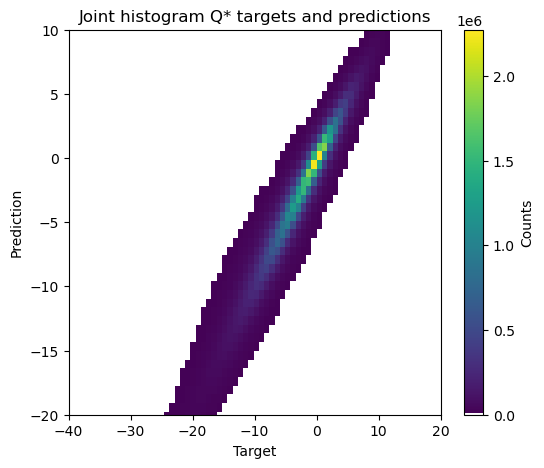

In [22]:
from matplotlib.colors import ListedColormap

# Flatten both datasets
vals1 = HF_test.ravel()
vals2 = sgs_pred.ravel()

# Create a colormap with white for zero counts
cmap = plt.get_cmap("viridis")
new_cmap = cmap(np.arange(cmap.N))
new_cmap[0, :] = [1, 1, 1, 1]  # first color -> white
new_cmap = ListedColormap(new_cmap)

plt.figure(figsize=(6,5))
h = plt.hist2d(vals1, vals2, bins=200, cmap=new_cmap)

plt.colorbar(h[3], label="Counts")

# Set x/y limits to focus on nonzero region
plt.xlim(-40, 20)  # example limits
plt.ylim(-20, 10)

plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title("Joint histogram Q* targets and predictions")
plt.show()


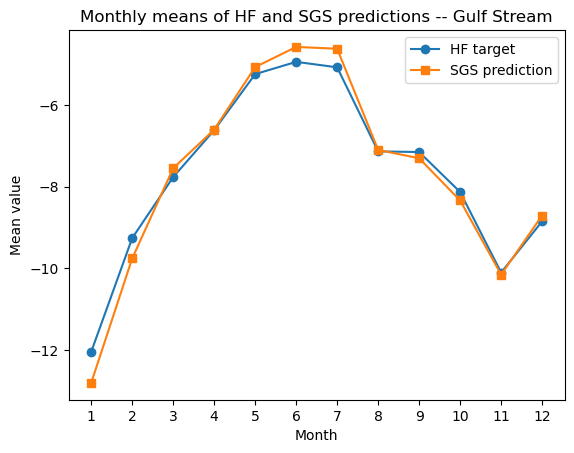

In [31]:
HF_test_reg1 = HF_test[0:365,:,:]
sgs_pred_reg1 = sgs_pred[0:365,:,:]

HF_monthly_means = []
sgs_monthly_means = []

for start, end in month_slices:
    HF_monthly_means.append(HF_test_reg1[start:end, :, :].mean())
    sgs_monthly_means.append(sgs_pred_reg1[start:end, :, :].mean())

# Plot
months = np.arange(1, 13)  # 1=Jan, 2=Feb, ..., 12=Dec
plt.plot(months, HF_monthly_means, marker='o', label='HF target')
plt.plot(months, sgs_monthly_means, marker='s', label='SGS prediction')
plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Mean value')
plt.title('Monthly means of HF and SGS predictions -- Gulf Stream')
plt.legend()
plt.show()

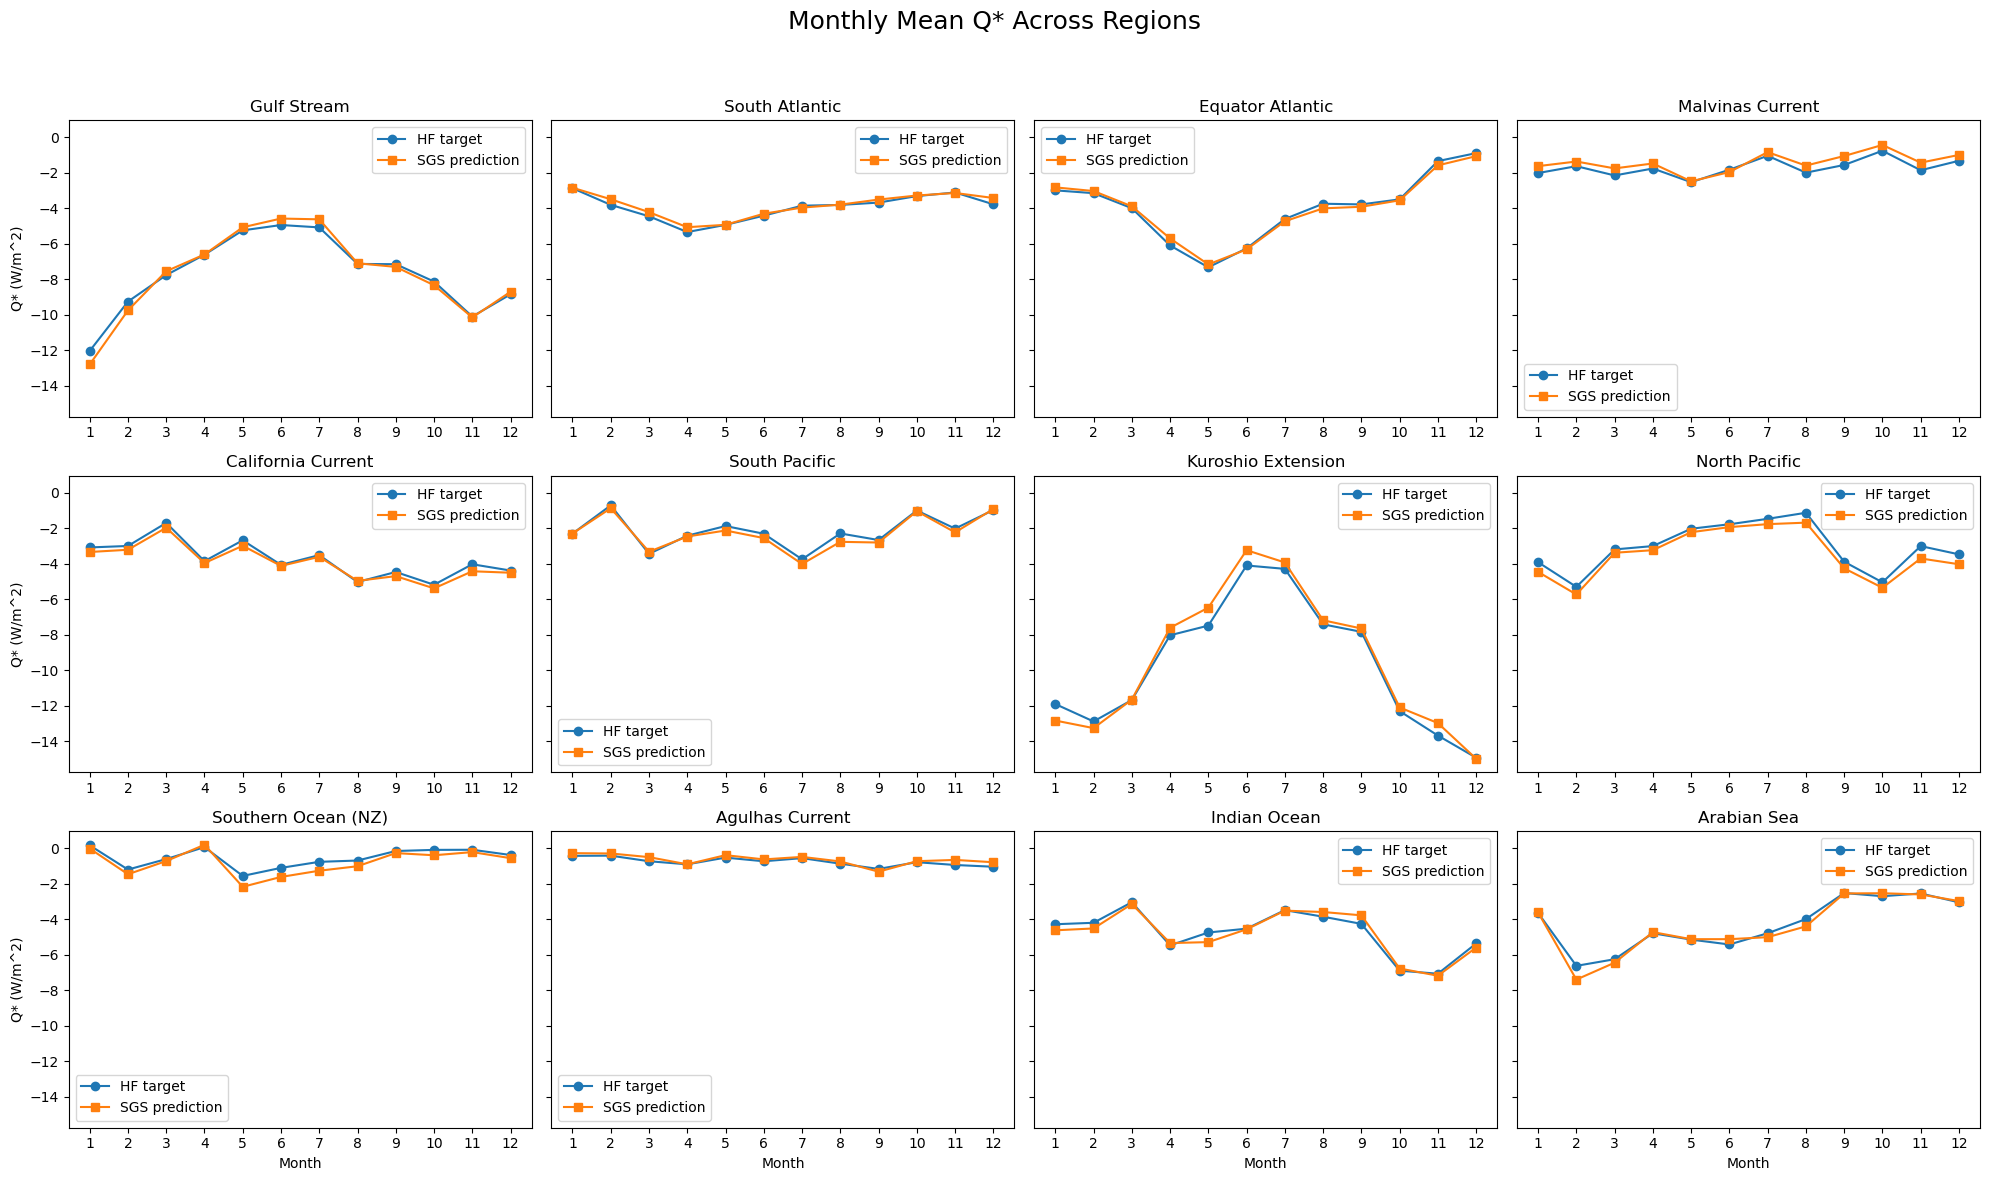

In [33]:
num_regions = 12
days_per_region = 365

fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharey=True)
axes = axes.flatten()  # easier indexing

for r in range(num_regions):
    # Slice the region's data
    start_idx = r * days_per_region
    end_idx = (r + 1) * days_per_region
    HF_region = HF_test[start_idx:end_idx, :, :]
    sgs_region = sgs_pred[start_idx:end_idx, :, :]

    # Compute monthly means
    HF_monthly_means = [HF_region[start:end, :, :].mean() for start, end in month_slices]
    sgs_monthly_means = [sgs_region[start:end, :, :].mean() for start, end in month_slices]

    months = np.arange(1, 13)
    ax = axes[r]
    ax.plot(months, HF_monthly_means, marker='o', label='HF target')
    ax.plot(months, sgs_monthly_means, marker='s', label='SGS prediction')
    ax.set_title(box_names[r])
    ax.set_xticks(months)
    if r % 4 == 0:
        ax.set_ylabel('Q* (W/m^2)')
    if r >= 8:
        ax.set_xlabel('Month')
    ax.legend()

plt.suptitle('Monthly Mean Q* Across Regions', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
